In [ ]:
from matplotlib_inline import backend_inline
import time

class Timer:
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add data points to the plot
        if not hasattr(self, 'plots'):
            self.plots = []
            for _ in range(len(y)):
                self.plots.append(self.axes[0].plot([], [], self.fmts[_ % len(self.fmts)])[0])
        for i, yi in enumerate(y):
            self.X[i].append(x)
            self.Y[i].append(yi)
            self.plots[i].set_data(self.X[i], self.Y[i])
        self.axes[0].relim()
        self.axes[0].autoscale_view()
        self.fig.canvas.draw()



def load_array(data_arrays, batch_size, is_train=True):
    """Construct a TensorFlow data iterator."""
    dataset = tf.data.Dataset.from_tensor_slices(data_arrays)
    if is_train:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    return dataset

def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    backend_inline.set_matplotlib_formats('svg')

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim), axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
X = tf.random.normal((1000, 2), 0.0, 1)
A = tf.constant([[1, 2], [-0.1, 0.5]])
b = tf.constant([1, 2], tf.float32)
data = tf.matmul(X, A) + b

The covariance matrix is
[[1.01 1.95]
 [1.95 4.25]]


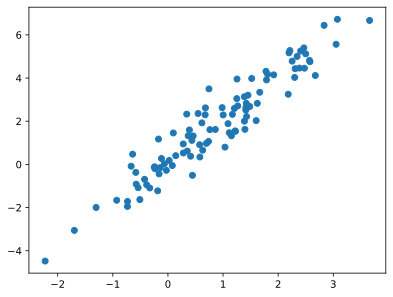

In [ ]:
plt.scatter(data[:100, 0].numpy(), data[:100, 1].numpy());
print(f'The covariance matrix is\n{tf.matmul(A, A, transpose_a=True)}')

In [ ]:
batch_size = 8
data_iter = load_array((data,), batch_size)

In [ ]:
net_G = tf.keras.layers.Dense(2)

In [ ]:
net_D = tf.keras.models.Sequential([
    tf.keras.layers.Dense(5, activation="tanh", input_shape=(2,)),
    tf.keras.layers.Dense(3, activation="tanh"),
    tf.keras.layers.Dense(1)
])

In [ ]:
def update_D(X, Z, net_D, net_G, loss, optimizer_D):
    """Update discriminator."""
    batch_size = X.shape[0]
    ones = tf.ones((batch_size,)) # Labels corresponding to real data
    zeros = tf.zeros((batch_size,)) # Labels corresponding to fake data
    # Do not need to compute gradient for `net_G`, so it is outside GradientTape
    fake_X = net_G(Z)
    with tf.GradientTape() as tape:
        real_Y = net_D(X)
        fake_Y = net_D(fake_X)
        loss_D = (loss(ones, tf.squeeze(real_Y)) + loss(
            zeros, tf.squeeze(fake_Y))) * batch_size / 2
    grads_D = tape.gradient(loss_D, net_D.trainable_variables)
    optimizer_D.apply_gradients(zip(grads_D, net_D.trainable_variables))
    return loss_D

In [ ]:
def update_G(Z, net_D, net_G, loss, optimizer_G):
    """Update generator."""
    batch_size = Z.shape[0]
    ones = tf.ones((batch_size,))
    with tf.GradientTape() as tape:
        # We could reuse `fake_X` from `update_D` to save computation
        fake_X = net_G(Z)
        # Recomputing `fake_Y` is needed since `net_D` is changed
        fake_Y = net_D(fake_X)
        # We multiply the loss by batch_size to match PyTorch's BCEWithLogits loss
        loss_G = loss(ones, tf.squeeze(fake_Y)) * batch_size
    grads_G = tape.gradient(loss_G, net_G.trainable_variables)
    optimizer_G.apply_gradients(zip(grads_G, net_G.trainable_variables))
    return loss_G

In [ ]:
def train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data):
    loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.SUM)
    for w in net_D.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))
    for w in net_G.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))
    optimizer_D = tf.keras.optimizers.Adam(learning_rate=lr_D)
    optimizer_G = tf.keras.optimizers.Adam(learning_rate=lr_G)

    for epoch in range(num_epochs):
        # Train one epoch
        timer = Timer()
        metric = Accumulator(3)  # loss_D, loss_G, num_examples
        for (X,) in data_iter:
            batch_size = X.shape[0]
            Z = tf.random.normal(
                mean=0, stddev=1, shape=(batch_size, latent_dim))
            metric.add(update_D(X, Z, net_D, net_G, loss, optimizer_D),
                       update_G(Z, net_D, net_G, loss, optimizer_G),
                       batch_size)

        Z = tf.random.normal(mean=0, stddev=1, shape=(100, latent_dim))
        fake_X = net_G(Z)
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]

    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec')

In [ ]:
lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.005, 2, 20
train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G,
      latent_dim, data[:100].numpy())

loss_D 0.693, loss_G 0.693, 97.8 examples/sec


In [ ]:
Z = tf.random.normal(mean=0, stddev=1, shape=(100, latent_dim))
net_G(Z)

<tf.Tensor: shape=(100, 2), dtype=float32, numpy=
array([[-5.2743316e-02, -3.2440054e-01],
       [ 9.7129524e-01,  9.7704566e-01],
       [ 2.9762822e-01,  1.1944754e+00],
       [-1.6930240e-01,  1.9468386e+00],
       [-4.8095459e-01,  4.9996650e-01],
       [-1.2282474e+00, -4.8257792e-01],
       [ 4.1814971e-01,  2.2566888e+00],
       [ 2.3228088e-01,  1.4024923e+00],
       [ 4.7785103e-02,  1.8862766e+00],
       [-1.9412997e+00, -3.3083334e+00],
       [ 1.4235270e+00,  2.4747293e+00],
       [ 9.8196357e-01,  2.8092804e+00],
       [ 1.1094036e+00,  3.2141104e+00],
       [ 3.2190710e-01, -3.3615148e-01],
       [-3.2546657e-01, -6.9982016e-01],
       [-7.5527674e-01, -1.7936075e-01],
       [ 1.1912472e+00,  3.5988002e+00],
       [ 3.1280354e-01,  1.7711351e+00],
       [-4.6216589e-01, -8.1811011e-01],
       [ 6.9047093e-02,  2.1000113e+00],
       [ 6.4540595e-02,  2.2104752e+00],
       [-2.4325013e-01,  1.1333315e+00],
       [ 3.0668068e-01,  1.9573572e+00],
       

In [ ]:
net_G(Z)[:,0]

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([-0.05274332,  0.97129524,  0.29762822, -0.1693024 , -0.4809546 ,
       -1.2282474 ,  0.4181497 ,  0.23228088,  0.0477851 , -1.9412997 ,
        1.423527  ,  0.9819636 ,  1.1094036 ,  0.3219071 , -0.32546657,
       -0.75527674,  1.1912472 ,  0.31280354, -0.4621659 ,  0.06904709,
        0.06454059, -0.24325013,  0.30668068,  1.9884303 ,  2.1325839 ,
        1.5468469 ,  0.4010893 ,  1.1070037 , -0.38056034, -1.0278823 ,
        1.2161548 ,  1.3562477 ,  0.11842102,  1.4797733 ,  1.1028447 ,
        0.85978276, -0.8605984 , -0.32398707, -0.28051704, -0.99374443,
        0.4156229 , -0.86386925,  1.7785861 ,  0.10483265,  1.5317247 ,
        0.03642339,  0.26297003,  2.6925585 ,  1.6084862 ,  0.8298873 ,
        1.5184693 ,  3.0640583 ,  2.4242206 ,  1.1281583 , -0.5305061 ,
        0.55197275, -0.28409058,  0.9095333 , -0.10027373, -2.8239975 ,
        1.1646092 ,  0.7123492 ,  0.94810283,  0.5172894 ,  1.4613155 ,
        0.470190

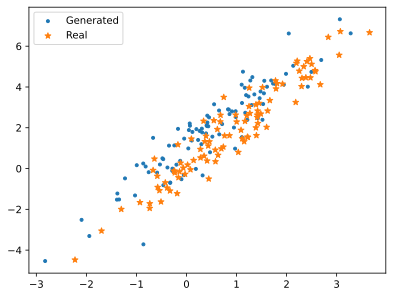

In [ ]:
plt.scatter(net_G(Z)[:,0].numpy(), net_G(Z)[:,1].numpy(), marker='.', label='Generated')
plt.scatter(data[:100, 0].numpy(), data[:100, 1].numpy(), marker='*', label='Real')
plt.legend()